# Blog Post Project with Boston Airbnb Data

# Business questions to answer

### The business questions this analysis aims at answering are:
    1. How long time does it take for most hosts to response?
    2. What are the top 3 factors that determines your listing rating?
    3. How does the sentiment landscape of our customer reviews looks like?

## Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Following lines need to run if required package not already downloaded. Commented out to avoid repeat downloading
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('words')
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('vader_lexicon')

import re

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


%matplotlib inline

## Load the data

In [2]:
bos_rev = pd.read_csv('./Data/reviews.csv')
bos_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [3]:
bos_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [4]:
bos_rev.shape

(68275, 6)

In [97]:
bos_list = pd.read_csv('./Data/listings.csv')
bos_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [9]:
bos_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [257]:
# Subseting the listing dataset by selecting useful columns only
df = bos_list[['id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_identity_verified', 'cleaning_fee', 
               'security_deposit', 'review_scores_rating', 'cancellation_policy', 'host_is_superhost']]
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_identity_verified,cleaning_fee,security_deposit,review_scores_rating,cancellation_policy,host_is_superhost
0,12147973,NaN,NaN,NaN,f,$35.00,NaN,NaN,moderate,f
1,3075044,within an hour,100%,100%,t,$10.00,$95.00,94.0,moderate,f
2,6976,within a few hours,100%,88%,t,NaN,NaN,98.0,moderate,t
3,1436513,within a few hours,100%,50%,f,$50.00,$100.00,100.0,moderate,f
4,7651065,within an hour,100%,100%,t,$15.00,NaN,99.0,flexible,t


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3585 non-null   int64  
 1   summary                 3442 non-null   object 
 2   host_response_time      3114 non-null   object 
 3   host_response_rate      3114 non-null   object 
 4   host_acceptance_rate    3114 non-null   object 
 5   host_identity_verified  3585 non-null   object 
 6   cleaning_fee            2478 non-null   object 
 7   security_deposit        1342 non-null   object 
 8   instant_bookable        3585 non-null   object 
 9   review_scores_rating    2772 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 280.2+ KB


In [22]:
df.shape

(3585, 10)

## EDA

### Check & deal with missing values

In [237]:
# Columns in df with no missing values

set(df.columns[df.isnull().mean() == 0])

{'cancellation_policy',
 'cleaning_fee_clean',
 'host_identity_verified',
 'host_is_superhost',
 'hostres_time_clean',
 'id',
 'instant_bookable',
 'review_scores_rating'}

In [199]:
# Columns in df with over 50% missing values
set(df.columns[df.isnull().mean() > 0.5])

{'security_deposit'}

In [258]:
# Drop the columns in df with over 50% missing values
df = df.drop(df.columns[df.isnull().mean() > 0.5], axis = 1)
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_identity_verified,cleaning_fee,review_scores_rating,cancellation_policy,host_is_superhost
0,12147973,NaN,NaN,NaN,f,$35.00,NaN,moderate,f
1,3075044,within an hour,100%,100%,t,$10.00,94.0,moderate,f
2,6976,within a few hours,100%,88%,t,NaN,98.0,moderate,t
3,1436513,within a few hours,100%,50%,f,$50.00,100.0,moderate,f
4,7651065,within an hour,100%,100%,t,$15.00,99.0,flexible,t


In [170]:
df.shape

(3585, 8)

In [259]:
# Drop any row containing NAN in intended dependent variable review_scores_rating
df = df.dropna(subset = 'review_scores_rating', how = 'any', axis = 0)
df.shape

(2772, 9)

In [13]:
# Columns in bos_rev with no missing values

set(bos_rev.columns[bos_rev.isnull().mean() == 0])

{'date', 'id', 'listing_id', 'reviewer_id', 'reviewer_name'}

In [16]:
# Columns in bos_rev with over 50% missing values
set(bos_rev.columns[bos_rev.isnull().mean() > 0.5])

set()

In [5]:
# Drop any row containing NAN in target variable for sentiment analysis - comments
bos_rev = bos_rev.dropna(subset = 'comments', how = 'any', axis = 0)
bos_rev.shape

(68222, 6)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 1 to 3583
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2772 non-null   int64  
 1   summary                 2644 non-null   object 
 2   host_response_time      2552 non-null   object 
 3   host_response_rate      2552 non-null   object 
 4   host_acceptance_rate    2552 non-null   object 
 5   host_identity_verified  2772 non-null   object 
 6   cleaning_fee            1980 non-null   object 
 7   instant_bookable        2772 non-null   object 
 8   review_scores_rating    2772 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 216.6+ KB


In [ ]:
bos_rev.info()

#### Comment

To start with, the listing and review datasets are loaded. Listing dataset is subsetted so that only columns that may be used are selected into my main dataframe - df. Subsetted listing dataset df contains 3585 rows and the review dataset contains 68275 rows before cleaning. 

The initial exploration of the listing and review data shows that there are missing values in both datasets. For the subsetted listing dataset(df), only 'security deposit' column contains more than 50% missing value and is therefore dropped. To answer our second business question, column 'review_scores_rating' will be used as target variable in a linear regression. Therefore, any rows containing missing value in 'review_score_rating' is dropped as well. This left us 2772 rows in df. For the review data, the 'comments' column is the target variable for sentiment analysis to answer the third business question. Thus, any row containing missing values in column 'comments' is dropped. This left us 68222 rows.

Now the initial cleaning is done, we will move onto data wrangling.

### Data Wrangling

In [6]:
# Extracting month from date column for both dataframes
# Converting nuemric month to actual month name

bos_rev['date'] = pd.to_datetime(bos_rev['date'])

dm_map = {
    1: 'January',
    2: 'Feburary',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

bos_rev['month'] = bos_rev['date'].dt.month.map(dm_map)

bos_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,May
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,May
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,June
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,June
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,June


In [260]:
# Convert cleaning fee to a float and fill the NAN in cleaning fee with mean
df['cleaning_fee_clean'] = df['cleaning_fee'].replace('[^.0-9]', '', regex=True).astype(float)

In [74]:
df['cleaning_fee_clean']

1       10.0
2        NaN
3       50.0
4       15.0
5       30.0
        ... 
3574     NaN
3575     NaN
3578     NaN
3580     NaN
3583     NaN
Name: cleaning_fee_clean, Length: 2772, dtype: float64

In [261]:
df['cleaning_fee_clean'].fillna(df['cleaning_fee_clean'].mean(), axis = 0, inplace = True)
df['cleaning_fee_clean'].value_counts()

65.682828     792
50.000000     267
100.000000    225
25.000000     179
10.000000     115
             ... 
54.000000       1
39.000000       1
84.000000       1
158.000000      1
59.000000       1
Name: cleaning_fee_clean, Length: 74, dtype: int64

In [262]:
df = df.drop('cleaning_fee', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 1 to 3583
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2772 non-null   int64  
 1   host_response_time      2552 non-null   object 
 2   host_response_rate      2552 non-null   object 
 3   host_acceptance_rate    2552 non-null   object 
 4   host_identity_verified  2772 non-null   object 
 5   review_scores_rating    2772 non-null   float64
 6   cancellation_policy     2772 non-null   object 
 7   host_is_superhost       2772 non-null   object 
 8   cleaning_fee_clean      2772 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 216.6+ KB


In [263]:
# Fill the NAN in host_response_time with string 'not recorded'
df['hostres_time_clean'] = df['host_response_time'].fillna('not recorded', axis = 0)
df['hostres_time_clean'].value_counts()

within an hour        1172
within a few hours     977
within a day           381
not recorded           220
a few days or more      22
Name: hostres_time_clean, dtype: int64

In [264]:
df = df.drop('host_response_time', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 1 to 3583
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2772 non-null   int64  
 1   host_response_rate      2552 non-null   object 
 2   host_acceptance_rate    2552 non-null   object 
 3   host_identity_verified  2772 non-null   object 
 4   review_scores_rating    2772 non-null   float64
 5   cancellation_policy     2772 non-null   object 
 6   host_is_superhost       2772 non-null   object 
 7   cleaning_fee_clean      2772 non-null   float64
 8   hostres_time_clean      2772 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 216.6+ KB


In [208]:
# Check cancellation policy category
df['cancellation_policy'].value_counts()

strict             1279
moderate            786
flexible            639
super_strict_30      68
Name: cancellation_policy, dtype: int64

In [265]:
# Create dummy variable for instant_bookable and host_identity_verified
df1 = pd.get_dummies(df[['host_identity_verified', 'cancellation_policy', 'host_is_superhost']], drop_first = True)
df = pd.concat([df, df1], axis = 1)

In [266]:
# Drop original column for two binary variable. Original column for host response time is needed for further analysis
df = df.drop(['host_identity_verified', 'cancellation_policy', 'host_is_superhost'], axis = 1)
df.head()

,id,host_response_rate,host_acceptance_rate,review_scores_rating,cleaning_fee_clean,hostres_time_clean,host_identity_verified_t,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,host_is_superhost_t
1,3075044,100%,100%,94.0,10.000000,within an hour,1,1,0,0,0
2,6976,100%,88%,98.0,65.682828,within a few hours,1,1,0,0,1
3,1436513,100%,50%,100.0,50.000000,within a few hours,0,1,0,0,0
4,7651065,100%,100%,99.0,15.000000,within an hour,1,0,0,0,1
5,12386020,100%,95%,100.0,30.000000,within a few hours,1,0,0,0,1


In [267]:
# Convert host_response_rate & host_acceptance rate and fill with mean
def conv_perc(x):
    return x.str.strip('%').astype('float')/100

In [268]:
df['hostres_rate_clean'] = conv_perc(df['host_response_rate'])
df['hostres_rate_clean'].fillna(df['hostres_rate_clean'].mean(), axis = 0, inplace = True)
df['hostres_rate_clean']

1       1.00
2       1.00
3       1.00
4       1.00
5       1.00
        ... 
3574    1.00
3575    0.96
3578    1.00
3580    0.96
3583    1.00
Name: hostres_rate_clean, Length: 2772, dtype: float64

In [269]:
df['hostacp_rate_clean'] = conv_perc(df['host_acceptance_rate'])
df['hostacp_rate_clean'].fillna(df['hostacp_rate_clean'].mean(), axis = 0, inplace = True)
df['hostacp_rate_clean']

1       1.00
2       0.88
3       0.50
4       1.00
5       0.95
        ... 
3574    1.00
3575    1.00
3578    1.00
3580    1.00
3583    0.96
Name: hostacp_rate_clean, Length: 2772, dtype: float64

In [270]:
df = df.drop(['host_acceptance_rate', 'host_response_rate'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 1 to 3583
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   2772 non-null   int64  
 1   review_scores_rating                 2772 non-null   float64
 2   cleaning_fee_clean                   2772 non-null   float64
 3   hostres_time_clean                   2772 non-null   object 
 4   host_identity_verified_t             2772 non-null   uint8  
 5   cancellation_policy_moderate         2772 non-null   uint8  
 6   cancellation_policy_strict           2772 non-null   uint8  
 7   cancellation_policy_super_strict_30  2772 non-null   uint8  
 8   host_is_superhost_t                  2772 non-null   uint8  
 9   hostres_rate_clean                   2772 non-null   float64
 10  hostacp_rate_clean                   2772 non-null   float64
dtypes: float64(4), int64(1), objec

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 1 to 3583
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   2772 non-null   int64  
 1   review_scores_rating                 2772 non-null   float64
 2   cleaning_fee_clean                   2772 non-null   float64
 3   hostres_time_clean                   2772 non-null   object 
 4   host_identity_verified_t             2772 non-null   uint8  
 5   cancellation_policy_moderate         2772 non-null   uint8  
 6   cancellation_policy_strict           2772 non-null   uint8  
 7   cancellation_policy_super_strict_30  2772 non-null   uint8  
 8   host_is_superhost_t                  2772 non-null   uint8  
 9   hostres_rate_clean                   2772 non-null   float64
 10  hostacp_rate_clean                   2772 non-null   float64
dtypes: float64(4), int64(1), objec

#### Comment

For data wrangling, 'date' column is the review data is converted to datetime object and a new column'month' is created to store the month extracted from 'date' column. For subsetted listing data df, 'cleaning fee' column is converted from currency to float number and all NAN values is filled with the average cleaning fee. As 'host_response_time' column stores string object, the missing values are filled with string 'not recorded'. For both 'host_response_rate' and 'host_acceptance_rate' column, values are converted from percentage to float first and NAN values are then filled with the mean value of each column. Moreover, dummy variables are created for categorical variable instant_bookable, host_identity_verified and hostres_time_clean for regression use. Lastly, original 'instant_bookable', 'host_identity_verified', 'cleaning fee', 'host_response_time', 'host_response_rate', 'host_acceptance_rate' columns are dropped from the df. We are now ready to answer our business questions.

## Analysis

### Answering Business Question 1

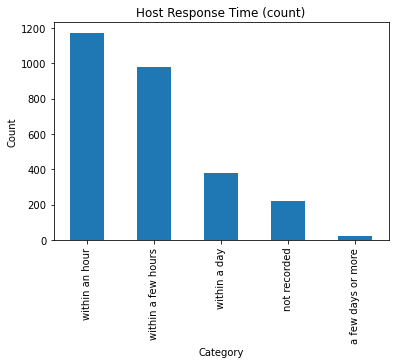

In [113]:
# Creating a bar plot to visualise the count of each category of 'host response time' column 

df['hostres_time_clean'].value_counts().plot(kind = 'bar')

plt.title('Host Response Time (count)')
plt.xlabel('Category')
plt.ylabel('Count')

plt.show()

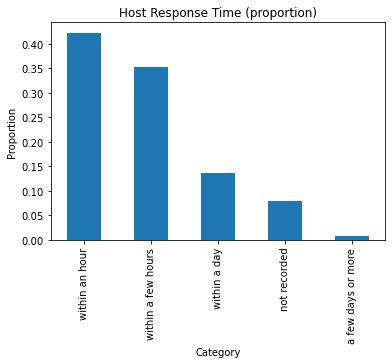

In [114]:
# Turning count into proportion
(df['hostres_time_clean'].value_counts()/df.shape[0]).plot(kind = 'bar')

plt.title('Host Response Time (proportion)')
plt.xlabel('Category')
plt.ylabel('Proportion')

plt.show()

#### Comment

The above analysis shows that over 40% of the Airbnb hosts response to customers' message within an hour, followed by the category within a few hours which makes up around 35% of the data. From above figures, we can come to the conclusion that the majority of Airbnb hosts tend to reply to customer messages within a couple of hours. This could be a useful reference for new hosts to determine their response schedule.

### Answering Business Question 2

In [272]:
# Train test split 
X = df.drop(['review_scores_rating', 'id', 'hostres_time_clean'], axis = 1)
y = df['review_scores_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [273]:
# Fit linear model with statsmodels for more information
X_train_sm = sm.add_constant(X_train)

lm = sm.OLS(y_train.astype(float), X_train_sm.astype(float)).fit()

In [274]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.062
Model:                              OLS   Adj. R-squared:                  0.058
Method:                   Least Squares   F-statistic:                     15.90
Date:                  Sun, 26 Feb 2023   Prob (F-statistic):           6.75e-23
Time:                          16:55:37   Log-Likelihood:                -7067.3
No. Observations:                  1940   AIC:                         1.415e+04
Df Residuals:                      1931   BIC:                         1.420e+04
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  86.4123      2.255     38.317      0.000      81.989      90.835
cleaning_fee_clean                      0.0035      0.005      0.681      0.496      -0.007       0.014
host_identity_verified_t                1.2758      0.509      2.507      0.012       0.278       2.274
cancellation_policy_moderate            0.8140      0.600      1.357      0.175      -0.362       1.990
cancellation_policy_strict             -0.4884      0.560     -0.872      0.383      -1.587       0.610
cancellation_policy_super_strict_30    -3.2824      1.462     -2.245      0.025      -6.150      -0.415
host_is_superhost_t                     5.6829      0.620      9.161      0.000       4.466       6.900
hostres_rate_clean                      3.3481      2.104      1.591      0.112      -0.778       7.474
hostacp_rate_clean                      0.5479      1.070      0.512      0.609      -1.551       2.647
==============================================================================
Omnibus:                     1266.608   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19669.152
Skew:                          -2.852   Prob(JB):                         0.00
Kurtosis:                      17.519   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [275]:
# Converting statsmodel summary table into pandas dataframe
results_lm = pd.read_html(lm.summary().tables[1].as_html(),header=0,index_col=0)[0]
results_lm

,coef,std err,t,P>|t|,[0.025,0.975]
const,86.4123,2.255,38.317,0.000,81.989,90.835
cleaning_fee_clean,0.0035,0.005,0.681,0.496,-0.007,0.014
host_identity_verified_t,1.2758,0.509,2.507,0.012,0.278,2.274
cancellation_policy_moderate,0.8140,0.600,1.357,0.175,-0.362,1.990
cancellation_policy_strict,-0.4884,0.560,-0.872,0.383,-1.587,0.610
cancellation_policy_super_strict_30,-3.2824,1.462,-2.245,0.025,-6.150,-0.415
host_is_superhost_t,5.6829,0.620,9.161,0.000,4.466,6.900
hostres_rate_clean,3.3481,2.104,1.591,0.112,-0.778,7.474
hostacp_rate_clean,0.5479,1.070,0.512,0.609,-1.551,2.647


In [276]:
# Extracting coefficient and p_values from statsmodel results and remove 'constant' row
results = results_lm.loc[:, ['coef', 'P>|t|']].iloc[1:]
results = results.rename(columns = {'coef': 'coefficient_statsmodel', 'P>|t|': 'p-value'})

In [277]:
# Fitting the model again with sklearn to predict on test set
lm_sk = LinearRegression(normalize = True)
lm_sk.fit(X_train, y_train)

C:\Users\Jessi\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [278]:
# Converting sklearn linear regression results to dataframe and compare with statsmodels
results['coefficient_sklearn'] = lm_sk.coef_
results

,coefficient_statsmodel,p-value,coefficient_sklearn
cleaning_fee_clean,0.0035,0.496,0.003488
host_identity_verified_t,1.2758,0.012,1.275785
cancellation_policy_moderate,0.8140,0.175,0.814031
cancellation_policy_strict,-0.4884,0.383,-0.488354
cancellation_policy_super_strict_30,-3.2824,0.025,-3.282378
host_is_superhost_t,5.6829,0.000,5.682934
hostres_rate_clean,3.3481,0.112,3.348099
hostacp_rate_clean,0.5479,0.609,0.547918


In [279]:
# Coloring variables whose effect is statistically significant (level of significance at 0.05) into red
def color_significant_red(val):
    """
    Takes a scalar and returns a string with a red color for negative strings, otherwise remains black.
    """
    if val < 0.05:
        color = 'red'  
    else: 
        color = 'black'
    return 'color: %s' % color

In [280]:
# Displaying results table with significant variables highlighted
results.style.applymap(color_significant_red, subset = ['p-value'])

,coefficient_statsmodel,p-value,coefficient_sklearn
cleaning_fee_clean,0.003500,0.496000,0.003488
host_identity_verified_t,1.275800,0.012000,1.275785
cancellation_policy_moderate,0.814000,0.175000,0.814031
cancellation_policy_strict,-0.488400,0.383000,-0.488354
cancellation_policy_super_strict_30,-3.282400,0.025000,-3.282378
host_is_superhost_t,5.682900,0.000000,5.682934
hostres_rate_clean,3.348100,0.112000,3.348099
hostacp_rate_clean,0.547900,0.609000,0.547918


In [281]:
results.style.applymap(color_significant_red, subset = ['p-value']).bar(subset=['coefficient_sklearn'], align='mid', color=['#d65f5f', '#5fba7d'])

,coefficient_statsmodel,p-value,coefficient_sklearn
cleaning_fee_clean,0.003500,0.496000,0.003488
host_identity_verified_t,1.275800,0.012000,1.275785
cancellation_policy_moderate,0.814000,0.175000,0.814031
cancellation_policy_strict,-0.488400,0.383000,-0.488354
cancellation_policy_super_strict_30,-3.282400,0.025000,-3.282378
host_is_superhost_t,5.682900,0.000000,5.682934
hostres_rate_clean,3.348100,0.112000,3.348099
hostacp_rate_clean,0.547900,0.609000,0.547918


In [282]:
# Predicting on test set
y_pred_train = lm_sk.predict(X_train)
y_pred = lm_sk.predict(X_test)

In [284]:
# Calculating Regression Evaluation Metrics
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Train R2', r2_score(y_train, y_pred_train))
print('Test R2', r2_score(y_test, y_pred))

RMSE: 9.279970955306808
Train R2 0.0617867423085533
Test R2 0.04472660832505859


#### Comment

##### Explaining model building strategy

To determine factors that may influence the rating score of a listing, linear regression model is used as the dependent variable 'review_scores_rating' is a continous variable. We used linear regression function from both statsmodel and sklearn packages as they provide us different informations. Coefficients from both methods are compared and determined to be the same. P-value from statsmodel is then used to determine whether the effect of our predictors are statistically significant. Lastly, r-squared score for both train and test dataset and root mean squred error are calculated for model performance evaluation.

##### Explaining the results and answer question 2

Firstly, let's have a look at our model results. From p-value column, we can deduce that cleaning fee, host response rate and host acceptance rate have no significant effect over the review rating score of a listing at significance level p=0.05. For categorical variable 'cancellation policy', only the effect of subcategory 'super_strict_30' is statistically significant. Moreover, whether a host is superhost also have meaningful impact on review rating score of a listing.

Now, let's focus on our predictors whose impact is statistically significant and explore more. From the coefficient column and the colored bar, we can see that the whether a host is superhost shows strongest effect on review rating score over other factors. A superhost on average has the a higher rating score by 5.68 units than those who are not. The second strongest predictor is the subcategory 'super_strict_30' for cancellation policy. For listings that has super strict cancellation policy, the review rating score is 3.28 unit lower on average compared to a flexible cancellation policy. Lastly, our third strongest predictor is whether the identity of the host has been verified. For listings that host identity has been verified, the review rating score is on average 1.28 unit higher than those host identity not verified.

Thus, we have the anwser to our business question 2. The top three factors affecting review rating score of a listing are: whether the host is a superhost, cancellation policy of the listing and whether the host identity has been verified.

##### Explaining model performance

The adjusted r-sqaured score of 0.058 suggests that our model has explained only 5.8% of the variance in review rating score, far from ideal. Comparing adjusted r2 and r2 for training set, we could discover that adjusted r2 is slightly smaller than normal r2. This is because adjusted r2 takes model complexity into account and punished the model if a independent variable does not improve the model. As for the comparison of model performance on training set and testing set, the r2 score for testset is about 0.02 smaller than the r2 score for trainset. This implies that the model performs slighly worse on testset.

Furthermore, let's look at the root mean squared error. Our model has a root mean squared error of 9.28. This suggests that The average of squared differences between the predicted rating score and actual rating score is 9.28 units. As a smaller root mean squared error is desired, our model still has room for improvement.

To conclude, our linear model performs relatively similar between training set and testing set. However, the model is far from ideal and requires improvement. The small adjusted r2 score suggested other independ variable could be added to explain more variance in review rating score. Moreover, a PCA could be implemented on all aspect of the reivew_score(value, rating and so on) and create a aggregated review_score dependent variable.

### Anwsering Business Question 3

#### Text Pre-processing

In [34]:
# Setting up non-english words corpus and pos tag dictionary
words = set(nltk.corpus.words.words())
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

In [37]:
# Pre-processing text - cleaning the text
def clean(corpus):
    # Transform all letter to lower cases, remove punctuation, potential URL and potential email address
    corpus = corpus.lower()
    corpus = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", corpus)
    
    # Tockenise corpus and add pos tag
    Tag = nltk.pos_tag(word_tokenize(corpus))
    
    # Removing all non-english words and common English stopwords
    new_corpus = []
    for word, tag in Tag:
        if word not in words or not word.isalpha():
            if word not in stopwords.words('English'):
                new_corpus.append(tuple([word, pos_dict.get(tag[0])]))
    return new_corpus

In [76]:
# Sampling from review dataset as the original dataset is too large and requires too much computational power
bos_rev_sample = bos_rev.sample(frac = 0.5, random_state = 2)
bos_rev_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34111 entries, 36033 to 561
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     34111 non-null  int64         
 1   id             34111 non-null  int64         
 2   date           34111 non-null  datetime64[ns]
 3   reviewer_id    34111 non-null  int64         
 4   reviewer_name  34111 non-null  object        
 5   comments       34111 non-null  object        
 6   month          34111 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.1+ MB


In [77]:
bos_rev_sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month
36033,8923817,64237120,2016-03-01,2300637,Robert,I could not imagine staying in a more beautifu...,March
38754,2295530,47476446,2015-09-19,39134213,Rik,Alicia and Kostas were fabulous hosts. They co...,September
62950,1472520,19030591,2014-09-05,15858786,Janina,La habitación era exactamente como se describí...,September
9553,4526315,24540514,2014-12-30,4811894,Jalin,Jared was a very welcoming and attentive host....,December
14382,5086521,78229235,2016-06-05,52947962,Asha,Ryan was a great host and his place is just as...,June


In [78]:
bos_rev_sample['comment_cleaned'] = bos_rev_sample['comments'].apply(clean)

In [79]:
bos_rev_sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month,comment_cleaned
36033,8923817,64237120,2016-03-01,2300637,Robert,I could not imagine staying in a more beautifu...,March,"[(staying, v), (jil, a), (walls, n), (makes, v..."
38754,2295530,47476446,2015-09-19,39134213,Rik,Alicia and Kostas were fabulous hosts. They co...,September,"[(alicia, n), (kostas, n), (hosts, n), (couldn..."
62950,1472520,19030591,2014-09-05,15858786,Janina,La habitación era exactamente como se describí...,September,"[(habitacin, n), (exactamente, n), (como, n), ..."
9553,4526315,24540514,2014-12-30,4811894,Jalin,Jared was a very welcoming and attentive host....,December,"[(jared, v), (located, v), (cared, v), (enjoye..."
14382,5086521,78229235,2016-06-05,52947962,Asha,Ryan was a great host and his place is just as...,June,"[(ryan, n), (cafes, n), (fens, n)]"


In [80]:
# Pre-processing text - lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize(corpus):
    lemma = []
    for word, pos in corpus:
        if not pos:
            lemma.append(word)
        else:
            lemma.append(lemmatizer.lemmatize(word, pos=pos))
    return lemma

In [81]:
bos_rev_sample['comment_lemma'] = bos_rev_sample['comment_cleaned'].apply(lemmatize).str.join(' ')

In [82]:
bos_rev_sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month,comment_cleaned,comment_lemma
36033,8923817,64237120,2016-03-01,2300637,Robert,I could not imagine staying in a more beautifu...,March,"[(staying, v), (jil, a), (walls, n), (makes, v...",stay jil wall make house tree jamaica plain ce...
38754,2295530,47476446,2015-09-19,39134213,Rik,Alicia and Kostas were fabulous hosts. They co...,September,"[(alicia, n), (kostas, n), (hosts, n), (couldn...",alicia kostas host couldnt centre restaurant a...
62950,1472520,19030591,2014-09-05,15858786,Janina,La habitación era exactamente como se describí...,September,"[(habitacin, n), (exactamente, n), (como, n), ...",habitacin exactamente como describa casa muy a...
9553,4526315,24540514,2014-12-30,4811894,Jalin,Jared was a very welcoming and attentive host....,December,"[(jared, v), (located, v), (cared, v), (enjoye...",jar locate care enjoy
14382,5086521,78229235,2016-06-05,52947962,Asha,Ryan was a great host and his place is just as...,June,"[(ryan, n), (cafes, n), (fens, n)]",ryan cafe fen


#### Applying Sentiment Analysis

In this analysis, the unsupervised lexical approach is used as there is no available sentiment label in the review dataset. Vader(Valence Aware Dictionary and sEntiment Reasoner) lexicon is adopted as it is specifically tunned for social media comments and views.

In [86]:
# Instantiate vader analyzer
analyzer = SentimentIntensityAnalyzer()

In [88]:
# Calculating sentiment score(i.e. polarity score)
def cal_sent_score(text):
    sent_score = analyzer.polarity_scores(text)['compound']
    return sent_score

In [89]:
bos_rev_sample['vader_sent_score'] = bos_rev_sample['comment_lemma'].apply(cal_sent_score)

In [90]:
bos_rev_sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month,comment_cleaned,comment_lemma,vader_sent_score
36033,8923817,64237120,2016-03-01,2300637,Robert,I could not imagine staying in a more beautifu...,March,"[(staying, v), (jil, a), (walls, n), (makes, v...",stay jil wall make house tree jamaica plain ce...,0.2023
38754,2295530,47476446,2015-09-19,39134213,Rik,Alicia and Kostas were fabulous hosts. They co...,September,"[(alicia, n), (kostas, n), (hosts, n), (couldn...",alicia kostas host couldnt centre restaurant a...,0.0000
62950,1472520,19030591,2014-09-05,15858786,Janina,La habitación era exactamente como se describí...,September,"[(habitacin, n), (exactamente, n), (como, n), ...",habitacin exactamente como describa casa muy a...,0.0000
9553,4526315,24540514,2014-12-30,4811894,Jalin,Jared was a very welcoming and attentive host....,December,"[(jared, v), (located, v), (cared, v), (enjoye...",jar locate care enjoy,0.7506
14382,5086521,78229235,2016-06-05,52947962,Asha,Ryan was a great host and his place is just as...,June,"[(ryan, n), (cafes, n), (fens, n)]",ryan cafe fen,0.0000


In [91]:
# Categorise and attach sentiment label
def sent_label(sent_score):
    if sent_score >= 0.5:
        return 'positive'
    elif sent_score <= -0.5:
        return 'negative'
    else:
        return 'neutral'

In [92]:
bos_rev_sample['vader_sent_label'] = bos_rev_sample['vader_sent_score'].apply(sent_label)

In [93]:
bos_rev_sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month,comment_cleaned,comment_lemma,vader_sent_score,vader_sent_label
36033,8923817,64237120,2016-03-01,2300637,Robert,I could not imagine staying in a more beautifu...,March,"[(staying, v), (jil, a), (walls, n), (makes, v...",stay jil wall make house tree jamaica plain ce...,0.2023,neutral
38754,2295530,47476446,2015-09-19,39134213,Rik,Alicia and Kostas were fabulous hosts. They co...,September,"[(alicia, n), (kostas, n), (hosts, n), (couldn...",alicia kostas host couldnt centre restaurant a...,0.0000,neutral
62950,1472520,19030591,2014-09-05,15858786,Janina,La habitación era exactamente como se describí...,September,"[(habitacin, n), (exactamente, n), (como, n), ...",habitacin exactamente como describa casa muy a...,0.0000,neutral
9553,4526315,24540514,2014-12-30,4811894,Jalin,Jared was a very welcoming and attentive host....,December,"[(jared, v), (located, v), (cared, v), (enjoye...",jar locate care enjoy,0.7506,positive
14382,5086521,78229235,2016-06-05,52947962,Asha,Ryan was a great host and his place is just as...,June,"[(ryan, n), (cafes, n), (fens, n)]",ryan cafe fen,0.0000,neutral


In [94]:
bos_rev_sample['vader_sent_label'].value_counts()

neutral     29789
positive     4108
negative      214
Name: vader_sent_label, dtype: int64

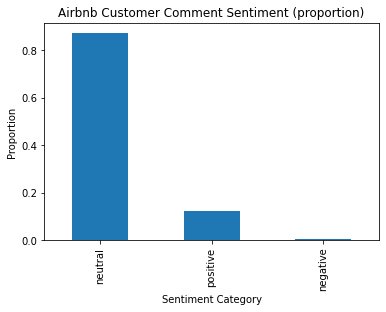

In [95]:
# Visualising sentiment landscape
(bos_rev_sample['vader_sent_label'].value_counts()/bos_rev_sample.shape[0]).plot(kind = 'bar')

plt.title('Airbnb Customer Comment Sentiment (proportion)')
plt.xlabel('Sentiment Category')
plt.ylabel('Proportion')

plt.show()

#### Comment

##### Explaining methodology

To answer business question 3, sentiment analysis is performed on the comments column in the review dataset. For any text analysis, the first step is text pre-processing. Letters are transformed to lower cases, punctuation and special characters removed. Texts are not tockenized into words with pos tags attached for each word. Pos tag helps identifying if a word is noun, verb, adjective etc. Words that are not English and common English stopwords are then removed. The last step of pre-processing is lemmatisation. 

Now, we have a clean text, sentiment analysis can be applied. As our review dataset does not contain a sentiment label column, we used an unsupervised lexical approach. Vader(Valence Aware Dictionary and sEntiment Reasoner) lexicon is adopted as it is specifically tunned for social media comments and views. After sentiment analysis is performed, we obtained a column of sentiment scores. Sentimen labels are then created based on the score. 

We are ready to answer our question.

##### Explaining results

From the bar plot on comment sentiment, we can deduce that the majority (over 80%) of the comments are actually neutral. Only a tiny percentage of comments are classified to have negative sentiment. However, we can also see that gaining a positive sentiment is not easy for hosts as only roughly around 15% of the customer comments are positive. This echos with some voices from the hosts that they feel like maintaining and improving relationship with customer is also part of their job. They need to be proactive, explaining the rules of Airbnb and help customers to understand how the rating and superhost scheme works.

## Conclusion

To conclude, in this project, we analysed data in Boston Airbnb listing and review dataset. From this project, we understand that most host tend to actively responding their customers, typically within an hour. The three top factors that determines the review rating score are whether a host is a superhost, whether the host identity has been verified and if the cancellation policy is super strict. The vast majority of customer comments is neutral and only a really tiny amount of comments are negative, suggesting a good commenting enviornment.

Thinking about the future, the linear model could be improved in various ways. As for the sentiment analysis, the sentimen score and label computed could be further used in regression analysis to understand what elemnts could potentially lead to a positive or negative comment. This could help hosts to understand better how they could gain more positive comments.